In [1]:
import msgpack
import pandas as pd

* For each bracket...
* Find the best score at each decision point

In [2]:
import toolz
from sklearn.utils import check_random_state
import itertools

In [3]:
pd.__version__

'0.23.0'

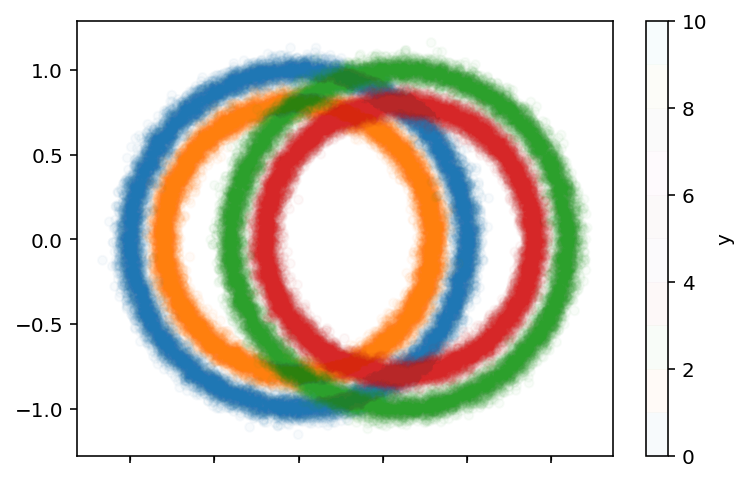

In [4]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X1, y1 = make_circles(n_samples=30_000, random_state=0, noise=0.04)
X2, y2 = make_circles(n_samples=30_000, random_state=1, noise=0.04)
X2[:, 0] += 0.6
X_info = np.concatenate((X1, X2))
y = np.concatenate((y1, y2 + 2))

df = pd.DataFrame(X_info)
df["y"] = y
ax = df.plot.scatter(x=0, y=1, c="y", cmap="tab10", vmax=10, alpha=0.03)
# ax.yaxis.set_major_locator(plt.NullLocator())
# ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel("")
plt.savefig("figs/synthetic-dataset.png", dpi=300, bbox_inches="tight")

In [6]:
today = "2019-06-22"

def _to_str_keys(d):
    if isinstance(d, list):
        return [_to_str_keys(di) for di in d]
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            out[_to_str_keys(k)] = _to_str_keys(v)
        return out
    if isinstance(d, bytes):
        return d.decode()
    return d
    
with open(f"out/{today}-histories-2.msgpack", "rb") as f:
    histories = msgpack.load(f)

histories = _to_str_keys(histories)

In [7]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [8]:
from sklearn.utils import check_random_state
def shape_history(history, seed=None, **kwargs):
#     global hist_df
    rng = check_random_state(int(seed))
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    print(seed, kwargs)
    start = history[0]["elapsed_wall_time"]
    
    if seed:
        model_history = toolz.groupby("model_id", history)
        for hist in model_history.values():
            for h in hist:
                h["elapsed_wall_time"] += rng.uniform(0, 0.3)
        hist = sum(model_history.values(), [])
        hist_df = pd.DataFrame(hist)
        hist_df.sort_values(by="elapsed_wall_time", inplace=True)
    else:
        hist_df = pd.DataFrame(history)
    
    for _, row in hist_df.iterrows():
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [9]:
import pandas as pd

hists = [
    shape_history(hist, seed=False, alg=alg, k=k)
    for alg, hists in histories.items()
    for k, hist in enumerate(hists)
#     for seed in range(3)
    for seed in [False]
]

False {'alg': 'hyperband', 'k': 0}
False {'alg': 'hyperband', 'k': 1}
False {'alg': 'hyperband', 'k': 2}
False {'alg': 'hyperband', 'k': 3}
False {'alg': 'hyperband', 'k': 4}
False {'alg': 'hyperband', 'k': 5}
False {'alg': 'hyperband', 'k': 6}
False {'alg': 'hyperband', 'k': 7}
False {'alg': 'hyperband', 'k': 8}
False {'alg': 'hyperband', 'k': 9}
False {'alg': 'hyperband', 'k': 10}
False {'alg': 'hyperband', 'k': 11}
False {'alg': 'hyperband', 'k': 12}
False {'alg': 'hyperband', 'k': 13}
False {'alg': 'hyperband', 'k': 14}
False {'alg': 'hyperband', 'k': 15}
False {'alg': 'hyperband', 'k': 16}
False {'alg': 'hyperband', 'k': 17}
False {'alg': 'hyperband', 'k': 18}
False {'alg': 'hyperband', 'k': 19}
False {'alg': 'hyperband', 'k': 20}
False {'alg': 'hyperband', 'k': 21}
False {'alg': 'hyperband', 'k': 22}
False {'alg': 'hyperband', 'k': 23}
False {'alg': 'hyperband', 'k': 24}
False {'alg': 'passive', 'k': 0}
False {'alg': 'passive', 'k': 1}
False {'alg': 'passive', 'k': 2}
False {'alg

In [10]:
def smooth(df, window=10):
#     summary = dict(df[["alg", "random_state", "k"]].iloc[0])
#     cols = ["best_score"]
#     scores = df.best_score
#     calls = df.cumulative_partial_fit_calls
    
#     avg_score = scores.rolling(window, center=True).mean()
#     avg_calls = calls.rolling(window, center=True).mean()
    col = "cumulative_partial_fit_calls"
    df[col] = np.round(df[col], decimals=-1) + 5
    return df
    
    return pd.DataFrame({"best_score": avg_score, "cumulative_partial_fit_calls": avg_calls, **summary})

dfs = [pd.DataFrame(hist) for hist in hists]
dfs = [smooth(df, window=100) for df in dfs]
df = pd.concat(dfs)
print(df.alg.unique())
print(df.cumulative_partial_fit_calls.describe())
df.head()

['hyperband' 'passive']
count    299475.000000
mean       3917.287937
std        2264.833532
min           5.000000
25%        1955.000000
50%        3925.000000
75%        5865.000000
max        7935.000000
Name: cumulative_partial_fit_calls, dtype: float64


,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,k,random_state
0,hyperband,0.257948,5,0.000000,0,0
1,hyperband,0.265547,5,0.000003,0,0
2,hyperband,0.265547,5,0.000004,0,0
3,hyperband,0.265547,5,0.000005,0,0
4,hyperband,0.314537,5,0.000006,0,0


In [11]:
import seaborn as sns

df["epochs"] = df["cumulative_partial_fit_calls"] / 3

kwargs = dict(
    index="epochs",
    values="best_score",
    columns="alg",
)

middle = df.pivot_table(aggfunc="mean", **kwargs)
lower = df.pivot_table(aggfunc=lambda x: x.quantile(q=0.10), **kwargs)
upper = df.pivot_table(aggfunc=lambda x: x.quantile(q=0.90), **kwargs)

In [12]:
middle.head()

alg,hyperband,passive
epochs,,
1.666667,0.273377,0.270796
5.000000,0.293402,0.296575
8.333333,0.306541,0.311915
11.666667,0.311589,0.327214
15.000000,0.318330,0.329198


passive
hyperband


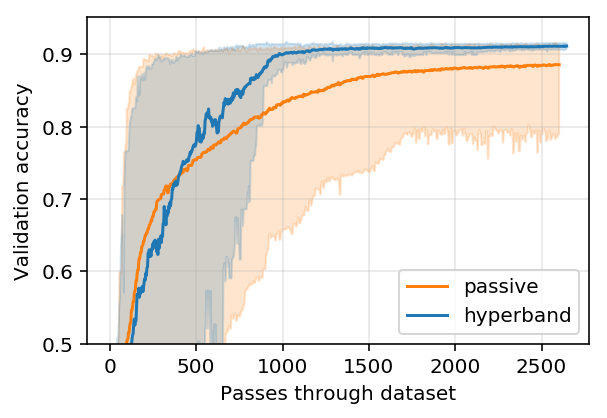

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

colors = {"hyperband": "C0", "passive": "C1"}
for alg in ["passive", "hyperband"]:
    print(alg)
    show_mid = middle[alg].dropna()
    show_low = lower[alg].dropna()
    show_upp = upper[alg].dropna()
    
    show_mid.plot(ax=ax, color=colors[alg])
#     show_low.plot(ax=ax, color=colors[alg], style="--")
    col = "epochs"
    ax.fill_between(show_low.index, show_low.values, show_upp.values, alpha=0.2, color=colors[alg])
ax.set_ylim(0.5, None)
ax.legend(loc="lower right")
ax.grid(linestyle="-", alpha=0.3)
ax.set_ylabel("Validation accuracy")

ax.set_xlabel("Passes through dataset")
plt.savefig("figs/synthetic-val-acc.pdf", bbox_inches="tight")

In [57]:
times = [508, 610, 445, 500, 609, 450, 429, 482, 562, 473, 464, 410,
         521, 530, 461, 472, 520, 543, 433, 383, 341, 424, 446]
np.mean(times) * 25 / 3600

3.326086956521739

In [42]:
# start at 7:30

In [59]:
times = [329, 394, 381, 540, 441, 375, 473]
np.mean(times) * 25 / 3600

2.9097222222222223